In [1]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import time
from scipy.integrate import quad
import cProfile

## Defining the integrand function and the integral function

In [2]:
#integrand = lambda x: np.sin(x)/x
def integrand(x):
    if isinstance(x,torch.Tensor):
        return torch.sin(x)/x
    else:
        return np.sin(x)/x
        
def integral(xmin,xmax):
    result,_ = quad(integrand,xmin,xmax)
    return result

## Constructing the network

In [3]:
device = torch.device('cpu')

def x_batcher(xmin,xmax,N):
    # Prepares a batch of x values in the [xmin,xmax] interval and the corresponding values of the integrand

    x_batch = xmin + (xmax-xmin)*torch.rand(N,1,requires_grad=True)
    y_batch = integrand(x_batch)
    return x_batch, y_batch

class NNIntegrate(nn.Module):
    # NN for the integration
    def __init__(self, hidden_dim, hidden_size, activation):
        '''
        hidden_dim: int
            The dimension of the hidden layer(s)
        hidden_size: int
            The number of hidden layers
        activation: nn Class
            Activation function class from torch.nn
        '''
        super().__init__()

        layers = []
        layers.append(nn.Linear(1,hidden_dim))
        layers.append(activation)

        for _ in range(hidden_size):
            layers.append(nn.Linear(hidden_dim,hidden_dim,dtype))
            layers.append(activation)

        layers.append(nn.Linear(hidden_dim,1))

        self.network = nn.Sequential(*layers)
    
    def forward(self, x):
        
        return self.network(x)
        

## Training the model

In [4]:
# Hyperparameters
hidden_dim = 10 # dimension of the hidden layer
hidden_size = 0  # Number of hidden layers

xmin = 0.0
xmax = 10.0
N_points = 1000

learning_rate = 0.01
decay_rate = 0.95
st_size = 200
num_epochs = 3000

x_batch, y_batch = x_batcher(xmin,xmax,N_points)

# Instantiate the model, define the loss function, optimizer and scheduler
model = NNIntegrate(hidden_dim,hidden_size,nn.Tanh())
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=st_size, gamma=decay_rate)

loss_arr = []
model.train()

start_time = time.time()

# Training loop
for epoch in range(num_epochs):
    
    prediction = model(x_batch)
    output_deriv = torch.autograd.grad(prediction, x_batch, torch.ones_like(prediction),create_graph=True)[0] # derivative
    loss = criterion(output_deriv,y_batch)
    
    optimizer.zero_grad()
    loss.backward(retain_graph=True) # since the graph is already created
    optimizer.step()
    scheduler.step()
    loss_arr.append(loss.detach().numpy())

    if epoch % (num_epochs // 10) == 0:
        print(f'Epoch {epoch}/{num_epochs}, Loss: {loss.item()}, lr: {optimizer.param_groups[0]["lr"]}')

print()
end_time = time.time()

train_time = end_time - start_time
print(f"Training time: {train_time} seconds")

Epoch 0/3000, Loss: 0.18748511373996735, lr: 0.01
Epoch 300/3000, Loss: 0.0034134730231016874, lr: 0.0095
Epoch 600/3000, Loss: 0.002943389117717743, lr: 0.00857375
Epoch 900/3000, Loss: 0.0007585803396068513, lr: 0.0081450625
Epoch 1200/3000, Loss: 0.0004307872732169926, lr: 0.007350918906249998
Epoch 1500/3000, Loss: 0.0003461273736320436, lr: 0.006983372960937498
Epoch 1800/3000, Loss: 0.0002926711458712816, lr: 0.006302494097246091
Epoch 2100/3000, Loss: 0.00021679165365640074, lr: 0.005987369392383786
Epoch 2400/3000, Loss: 4.827978409593925e-05, lr: 0.005403600876626367
Epoch 2700/3000, Loss: 2.3453603716916405e-05, lr: 0.005133420832795048

Training time: 1.8508222103118896 seconds


Plot the evolution of loss

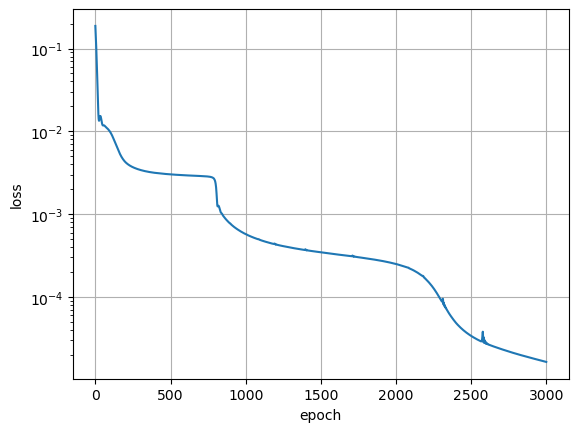

In [5]:
plt.figure()
plt.semilogy(range(num_epochs),loss_arr)
plt.grid()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

## Evaluate the model and compare the results

In [6]:
# Should be within the limits in which the model was trained
x_min = 0.0
x_max = 9.0

# Neural network (NN) result
model.eval()
result_NN = (model(torch.tensor([x_max],dtype=torch.float,requires_grad=False)) - model(torch.tensor([x_min],dtype=torch.float,requires_grad=False))).detach().numpy().item()

# Numerical integration 
result_NI = integral(x_min,x_max)

print(f"NN result: {result_NN}")
print(f"NI result: {result_NI}")

# Number of iterations to run the time test
N_test_points = 1000

start_time_NN = time.time()

# Run the calculation N_test_points times to determine the average CPU time
for i in range(N_test_points):
    result_NN = (model(torch.tensor([x_max])) - model(torch.tensor([x_min]))).detach().numpy().item()

end_time_NN = time.time()

# Average time
NN_time = (end_time_NN - start_time_NN)/N_test_points

# Do the same for the standard quadrature
start_time_NI = time.time()

for i in range(N_test_points):
    result_NI = integral(x_min,x_max)

end_time_NI = time.time()

NI_time = (end_time_NI - start_time_NI)/N_test_points

print(f"NN timing: {NN_time} s, NI timing: {NI_time} s")

NN result: 1.6658122539520264
NI result: 1.6650400758296027
NN timing: 8.04443359375e-05 s, NI timing: 1.904439926147461e-05 s


In [ ]:
#cProfile.run('model(torch.tensor([x_min]))')

As expected, the classical numerical integration outperforms the PyTorch network in speed for simple functions. Let's try to create a neural network using NumPy methods to reduce the CPU time

## Constructing the neural network with the parameters established by learning in NumPy

In [8]:
state_dict = model.state_dict() # a dictionary that contains model parameters

Print the network weights and biases

In [9]:
for name, param in state_dict.items():
    print(f"{name}:\n{param}\n")

network.0.weight:
tensor([[ 0.9646],
        [-0.7336],
        [ 0.6656],
        [-0.6663],
        [ 0.6400],
        [-0.5782],
        [-1.0056],
        [-0.6125],
        [ 0.2933],
        [-0.3574]])

network.0.bias:
tensor([ 0.1729, -0.0404, -4.1210, -1.1642, -0.4872,  4.5472, -0.1731,  0.8907,
        -1.7957, -0.3535])

network.2.weight:
tensor([[ 0.1971, -0.0915,  0.4584, -0.0619,  0.5731, -0.7210, -0.2826, -0.6392,
         -1.7224, -0.0410]])

network.2.bias:
tensor([0.1070])



Extracting the network parameters (by hand for the given network architecture)

In [32]:
#fc1_weight = state_dict['network.0.weight'].numpy()
#fc2_weight = state_dict['network.2.weight'].numpy()
#fc1_bias = state_dict['network.0.bias'].numpy()
#fc2_bias = state_dict['network.2.bias'].numpy()

Construct the NumPy network

In [60]:
# Define activation function
def tanh(x):
    return np.tanh(x)

# Neural network based on NumPy
class NumpyNetwork:

    def __init__(self,state_dict,activation):
        '''
        state_dict: dict
            Dictionary with weights and biases of a PyTorch network
        activation: Callable[[float],float]
            Activation function
        '''
        self.activation = activation 
        self.num_layers = len(state_dict) // 2 # number of layers in the network
        self.weights = []
        self.biases = []

        # Extract the weights and biases from the dictionary and store them in the corresponding lists
        for i,param in enumerate(state_dict.values()):
            if i % 2 == 0:
                self.weights.append(param.numpy())
            else:
                self.biases.append(param.numpy())

    # Define forward pass using NumPy
    def forward(self,x):
        # Input to first hidden later
        hidden = self.activation(np.dot(x, self.weights[0].T) + self.biases[0])
        # Iterate through all the hidden layers
        for i in range(1,self.num_layers-1):
            hidden = self.activation(np.dot(hidden, self.weights[i].T) + self.biases[i])
        # Hidden to output layer
        output = np.dot(hidden, self.weights[-1].T) + self.biases[-1]
        return output

    def evaluate(self,x):

        return self.forward(x)
        

## Evaluate the NumPy NN and compare the results

In [62]:
numpy_model = NumpyNetwork(state_dict,tanh)

start_time_NNnum = time.time()

for i in range(N_test_points):
    result_NNnum = numpy_model.evaluate(x_max) - numpy_model.evaluate(x_min)

end_time_NNnum = time.time()

NNnum_time = (end_time_NNnum - start_time_NNnum)/N_test_points

print(f"NNnum result: {result_NNnum}")
print(f"NI result: {result_NI}")
print(f"NNnum timing: {NNnum_time} s")
print(f"NI timing: {NI_time} s")

NNnum result: [[1.6658124]]
NI result: 1.6650400758296027
NNnum timing: 1.3818740844726563e-05 s
NI timing: 1.904439926147461e-05 s


For the given integrand function, boundaries and precision the NumPy NN for integration slightly outperforms the standard quadrature in terms of speed